In [1]:
import pandas as pd
from itertools import product

df = pd.read_csv("all_results_final.csv")
df.columns

Index(['Thorium Chain', 'U233 Input', 'U235 Input', 'PUTOT Input',
       'Original Lattice length', 'Original Coolant temperature',
       'Moderator radius', 'BURNUP (Mwd/t)', 'temps (s)',
       'Vol fuel (cm3) for cm height 2d', 'U233', 'U234', 'U235', 'U236',
       'U238', 'TH232', 'PU238', 'PU239', 'PU240', 'PU241', 'PU242', 'AM241',
       'AM242', 'CM242', 'CM243', 'CR', 'CR Masse',
       'Value of moderation ration Vm/Vfuel',
       'Value of ratio pitch/diameter (-)', 'Value of pitch (cm)',
       'Value of Temperature of coolant (°C)',
       'Value of density of coolant (°C)',
       'Value of boron concentration in coolant (ppm)',
       'Value of Temperature of fuel (°C)', 'Value of content (%) in U233',
       'Value of content (%) in U235', 'Value of content (%) in Pu tot',
       'KEFF (PCM)', 'KINF (PCM)', 'M2 (CM2)', 'B2 (CM-2)'],
      dtype='object')

In [ ]:
alpha_ = ["Thorium Chain", "U233 Input", "U235 Input", "PUTOT Input", "Original Lattice length", "BURNUP (Mwd/t)", "Original Coolant temperature", "KINF (PCM)"]

def calculate_alpha_coolant(grouped_df):
    if len(grouped_df) == 1:
        if len(grouped_df[grouped_df["Original Coolant temperature"] == 300.0]) != 1:
            print(grouped_df)
            raise
    assert len(grouped_df) == 2
    line_300 = grouped_df[grouped_df["Original Coolant temperature"] == 300.0]
    line_305 = grouped_df[grouped_df["Original Coolant temperature"] == 305.0]
    rho_300 = (line_300["KINF (PCM)"].iloc[0] - 1) / line_300["KINF (PCM)"].iloc[0]
    rho_305 = (line_305["KINF (PCM)"].iloc[0] - 1) / line_305["KINF (PCM)"].iloc[0]
    ret = (rho_305 - rho_300) * 100000 / 5.0
    return ret

df_alpha_mod = df.groupby(groupby_col).apply(calculate_alpha_coolant)

In [155]:
from tqdm import tqdm
import numpy as np
import scipy.interpolate as interpolate
import scipy.optimize as optimize

def get_fissile(grouped_df):
    if grouped_df["U233 Input"].iloc[0] > 0.01:
        return "U233"
    elif grouped_df["U235 Input"].iloc[0] > 0.01:
        return "U235"
    elif grouped_df["PUTOT Input"].iloc[0] > 0.01:
        return "PU239"
    raise


def calculate_alpha_coolant_at_burnup_0(grouped_df):
    df_brunup_0 = grouped_df[grouped_df["BURNUP (Mwd/t)"] == 0]
    if len(df_brunup_0) == 1:
        return None
    line_300 = df_brunup_0[df_brunup_0["Original Coolant temperature"] == 300.0]
    line_305 = df_brunup_0[df_brunup_0["Original Coolant temperature"] == 305.0]
    rho_300 = (line_300["KINF (PCM)"].iloc[0] - 1) / line_300["KINF (PCM)"].iloc[0]
    rho_305 = (line_305["KINF (PCM)"].iloc[0] - 1) / line_305["KINF (PCM)"].iloc[0]
    ret = (rho_305 - rho_300) * 100000 / 5.0
    return ret

def solve_cell_discharge_burnup(grouped_df):
    burnup = grouped_df["BURNUP (Mwd/t)"]

    if grouped_df["KINF (PCM)"].iloc[0] < 1:
        return -1
    if all(grouped_df["KINF (PCM)"] > 1):
        return 1e10

    func = interpolate.interp1d(burnup, grouped_df["KINF (PCM)"], kind='cubic')
    return optimize.brentq(lambda x: func(x)-1, burnup.min(), burnup.max())
    
def get_interpolated_values_at_specific_burnup(grouped_df, discharge_burnup, fissile):
    burnup = grouped_df["BURNUP (Mwd/t)"]
    if discharge_burnup < burnup.min() or discharge_burnup > burnup.max():
        return None, None, None

    func_cr = interpolate.interp1d(burnup , grouped_df["CR"], kind='cubic')
    cr = func_cr(discharge_burnup)

    func_u233 = interpolate.interp1d(burnup , grouped_df["U233"], kind='cubic')
    u233_ratio = func_u233(discharge_burnup) / grouped_df[fissile].iloc[0]

    sum_pu = grouped_df[["PU238", "PU239", "PU240", "PU241", "PU242"]].sum(axis=1)
    pu_239 = grouped_df["PU239"]
    func_sum_pu = interpolate.interp1d(burnup , sum_pu, kind='cubic')
    func_pu239 = interpolate.interp1d(burnup , pu_239, kind='cubic')
    pu239_ratio = func_pu239(discharge_burnup) / func_sum_pu(discharge_burnup)

    return cr, u233_ratio, pu239_ratio

ret = []
for keys, grouped_df in tqdm(df.groupby(["Thorium Chain", "U233 Input", "U235 Input", "PUTOT Input", "Original Lattice length"])):
    grouped_df = grouped_df.copy()
    alpha_coolant_at_burnup_0 = calculate_alpha_coolant_at_burnup_0(grouped_df)
    grouped_df = grouped_df[grouped_df["Original Coolant temperature"] == 300].sort_values("BURNUP (Mwd/t)").reset_index(drop=True)

    appolo_cell_discharge_burnup = solve_cell_discharge_burnup(grouped_df)
    true_discharge_burnup = 2 * appolo_cell_discharge_burnup
    initial_fissile = get_fissile(grouped_df)
    cr_appolo, u233_ratio_appolo, pu239_ratio_appolo = get_interpolated_values_at_specific_burnup(grouped_df, appolo_cell_discharge_burnup, initial_fissile)
    cr_true, u233_ratio_true, pu239_ratio_true = get_interpolated_values_at_specific_burnup(grouped_df, true_discharge_burnup, initial_fissile)
    
    more_value = list(grouped_df[["Moderator radius", "Value of moderation ration Vm/Vfuel", "Value of Temperature of coolant (°C)", "Value of density of coolant (°C)"]].iloc[0])
    ret.append(list(keys) + more_value + [appolo_cell_discharge_burnup, true_discharge_burnup, alpha_coolant_at_burnup_0, initial_fissile, cr_appolo, u233_ratio_appolo, pu239_ratio_appolo, cr_true, u233_ratio_true, pu239_ratio_true])

output_df = pd.DataFrame(ret)
columns = ["Thorium Chain", "U233 Input", "U235 Input", "PUTOT Input", "Original Lattice length", "Moderator radius", "Value of moderation ration Vm/Vfuel", "Value of Temperature of coolant (°C)", "Value of density of coolant (°C)", "Discharge Burnup (Apollo)", "Discharge Burnup (True)", "Alpha coolant at burnup 0", "Initial fissile material", "Conversion ratio (Apollo)", "U233 creation ratio (Apollo)", "PU239 ratio (Apollo)", "Conversion ratio (True)", "U233 creation ratio (True)", "PU239 ratio (True)"]
output_df.columns = columns
output_df = output_df.fillna(value=np.nan)
output_df[["Conversion ratio (Apollo)", "Conversion ratio (True)"]] = output_df[["Conversion ratio (Apollo)", "Conversion ratio (True)"]].astype(float)

100%|██████████| 913/913 [00:01<00:00, 754.36it/s]


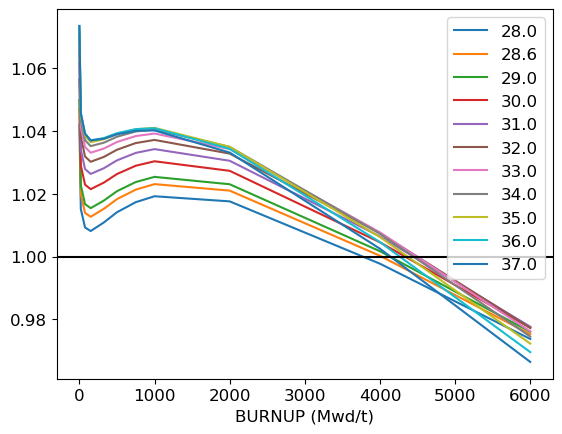

In [261]:
import matplotlib.pyplot as plt

pd.set_option('display.max_columns', 500)

test = df[(df["Thorium Chain"] == "NO") & (df["U235 Input"] == 0.719) & (df["Original Coolant temperature"] == 300)]
test = test[test["BURNUP (Mwd/t)"] < 6000]
test.set_index("BURNUP (Mwd/t)", inplace=True)
test = test[test["Original Lattice length"] > 27]
test = test[test["Original Lattice length"] < 38]


test.groupby("Original Lattice length")["KINF (PCM)"].plot(legend=True)
plt.axhline(y=1, color='black', linestyle='-')

/var/folders/mp/f920xbhn2ls61x4rb5mwdnrw0000gn/T/ipykernel_55226/3137955613.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test["Discharge Burnup (Apollo)"] = test["Discharge Burnup (Apollo)"].replace(1e10, np.nan)
/var/folders/mp/f920xbhn2ls61x4rb5mwdnrw0000gn/T/ipykernel_55226/3137955613.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test["Discharge Burnup (Apollo)"] = test["Discharge Burnup (Apollo)"].replace(-1, np.nan)


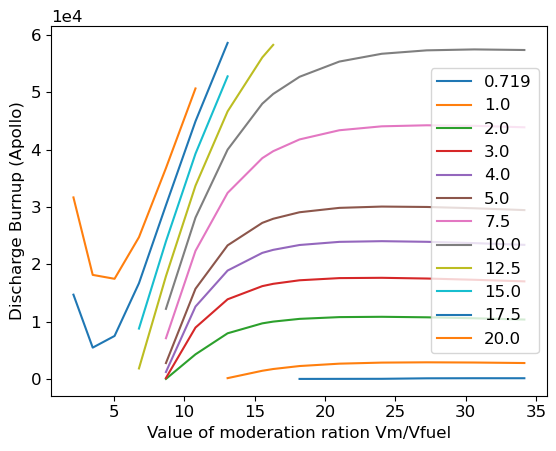

In [264]:
import matplotlib
matplotlib.rcParams.update({'font.size': 12})

fissile = "PUTOT Input"
small_name = "U5" if fissile == "U235" else "Pu9" if fissile == "PUTOT Input" else "U3"
test = output_df[(output_df["Thorium Chain"] == "NO") & (output_df[fissile] > 0.01)] # & (output_df[fissile] < 15)]
# test[fissile] = f"{small_name}=" + output_df[fissile].astype("str") + "%"
# test = test.sort_values(fissile)

test["Discharge Burnup (Apollo)"] = test["Discharge Burnup (Apollo)"].replace(1e10, np.nan)
test["Discharge Burnup (Apollo)"] = test["Discharge Burnup (Apollo)"].replace(-1, np.nan)

test.set_index("Value of moderation ration Vm/Vfuel", inplace=True)
ax = test.groupby(fissile)["Discharge Burnup (Apollo)"].plot(legend=True, ylabel="Discharge Burnup (Apollo)")
ax[3.0].ticklabel_format(axis='y', style='sci', useOffset=False, scilimits=(0, 0))
# ax[3.0].axhline(y=1, color= 'black', linewidth=1)